In [1]:
%env NCCL_LL128_BUFFSIZE=-2
%env NCCL_LL_BUFFSIZE=-2
%env NCCL_PROTO=SIMPLE,LL,LL128
%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.99
%env JAX_THREEFRY_PARTITIONABLE=true
%env TF_CPP_MIN_LOG_LEVEL=3

# !wget -q https://www.gutenberg.org/files/26268/mp3/26268-01.mp3 -O romeo_and_juliet.mp3

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import soundfile
import optax
import tqdm

from collections import defaultdict
from dataclasses import dataclass
from functools import partial
from pprint import pprint

from flax import nnx
from flax.nnx.nn.linear import default_embed_init
from jax.ad_checkpoint import checkpoint_name as ckpt
from jax.sharding import Mesh, PartitionSpec, NamedSharding
from IPython.display import Audio


default_dtype = (
    # jnp.float32
    jnp.bfloat16
)


mesh = Mesh(
    devices=np.array(jax.devices()), 
    axis_names=("data",)  # Plain old data parallelism. 
)


def gumbel_softmax(
    key: jax.Array, 
    logits: jax.Array, 
    *,
    hard: bool,
    temperature: float = 1.0, 
    axis: int = -1,
) -> jax.Array:
    logits += jax.random.gumbel(key, logits.shape)
    probs = nnx.softmax(logits / temperature, axis=axis)
    if not hard:
        return probs
    index = probs.argmax(axis)
    onehot = nnx.one_hot(index, probs.shape[axis], axis=axis, dtype=probs.dtype)
    straight_through = probs + jax.lax.stop_gradient(onehot - probs)
    return straight_through


def reconstruction_loss_fn(preds: jax.Array, batch: jax.Array) -> jax.Array:
    p = (batch.shape[1] - preds.shape[1]) // 2
    loss = jnp.mean((preds - batch[:, p:-p]) ** 2)
    return loss


def diversity_loss_fn(logits: jax.Array) -> jax.Array:
    codebook_size = logits.shape[-1]
    avg_probs = nnx.softmax(logits).mean((0, 1))
    entropy = -jnp.sum(avg_probs * jnp.log(avg_probs + 1e-7))
    perplexity = jnp.exp(entropy)
    loss = (codebook_size - perplexity) / codebook_size
    return loss


def tree_norm(tree) -> jax.Array:
    return jnp.linalg.norm(jnp.stack(jax.tree.flatten(jax.tree.map(jnp.linalg.norm, tree))[0]))


class ResBlock(nnx.Module):

    def __init__(self, dim: int, kernel_size: int, *, rngs: nnx.Rngs):
        self.conv = nnx.Conv(dim, 2 * dim, (kernel_size,), param_dtype=default_dtype, rngs=rngs)
        self.alpha = nnx.Param(jnp.zeros((), dtype=default_dtype))

    def __call__(self, x: jax.Array) -> jax.Array:
        x0 = x
        x = self.conv(x)
        x = ckpt(x, "conv")
        x = nnx.glu(x)
        x *= self.alpha
        x += x0
        return x


class Backbone(nnx.Module):

    def __init__(self, depth: int, dim: int, kernel_size: int, *, rngs: nnx.Rngs):

        @nnx.split_rngs(splits=depth)
        @nnx.vmap
        def create_block(rngs: nnx.Rngs):
            return ResBlock(dim, kernel_size, rngs=rngs)

        self.p = depth * (kernel_size // 2)
        self.blocks = create_block(rngs)

    def __call__(self, x: jax.Array) -> jax.Array:

        @nnx.scan(in_axes=(0, nnx.Carry), out_axes=nnx.Carry)
        @nnx.remat(prevent_cse=False, policy=jax.checkpoint_policies.save_only_these_names("conv"))
        def forward(block, x):
            return block(x)

        x = forward(self.blocks, x)
        return x[:, self.p:-self.p]
    
    
class ConvNet(nnx.Module):
    
    def __init__(
        self, 
        direction: str,
        *, 
        octaves: int, 
        depth: int, 
        dim: int, 
        kernel_size: int, 
        rngs: nnx.Rngs,
    ):
        assert direction in ("up", "down")
        self.direction = direction
        self.octaves = octaves
        self.backbones = [Backbone(depth, dim * 2 ** o, kernel_size, rngs=rngs) for o in range(octaves + 1)]
        if self.direction == "up":
            self.backbones = self.backbones[::-1]

    def __call__(self, x: jax.Array) -> jax.Array:
        for i, backbone in enumerate(self.backbones):
            if self.direction == "up" and i > 0:
                x = x.reshape(-1, x.shape[1] * 2, x.shape[2] // 2)
            x = backbone(x)
            if self.direction == "down" and i < self.octaves:
                x = x.reshape(-1, x.shape[1] // 2, x.shape[2] * 2)
        return x
        
    
class VQVAE(nnx.Module):

    def __init__(
        self,
        *,
        octaves: int,
        depth: int,
        dim: int,
        kernel_size: int,
        codebook_size: int,
        rngs: nnx.Rngs,
    ):
        self.octaves = octaves
        self.depth = depth
        self.dim = dim
        self.kernel_size = kernel_size
        self.codebook_size = codebook_size
        self.code_dim = dim * 2 ** octaves
        self.rngs = rngs
        
        linear = partial(nnx.Linear, param_dtype=default_dtype, rngs=rngs)
        convnet = partial(ConvNet, octaves=octaves, depth=depth, dim=dim, kernel_size=kernel_size, rngs=rngs)
        
        self.linear_in = linear(1, dim)
        self.encoder = convnet("down")
        self.proj = linear(self.code_dim, codebook_size)
        self.codebook = nnx.Param(default_embed_init(rngs.params(), (codebook_size, self.code_dim), dtype=default_dtype))
        self.decoder = convnet("up")
        self.linear_out = linear(dim, 1)
        
    def encode(self, x: jax.Array) -> jax.Array:
        x = self.linear_in(x)
        x = self.encoder(x)
        x = self.proj(x)
        return x
    
    def quantize(self, logits: jax.Array, temperature: float = 1.0) -> jax.Array:
        key = self.rngs.gumbel_softmax()
        onehots = gumbel_softmax(key, logits, temperature=temperature, hard=True)
        codes = onehots @ self.codebook
        return codes
    
    def decode(self, x: jax.Array) -> jax.Array:
        x = self.decoder(x)
        x = self.linear_out(x)
        return x
        
    def __call__(self, x: jax.Array, temperature: float = 1.0) -> tuple[jax.Array, jax.Array]:
        logits = self.encode(x)
        x = self.quantize(logits, temperature)
        x = self.decode(x)
        return x, logits

    def valid_length(self, bottleneck: int) -> int:
        length = bottleneck + (self.kernel_size - 1) * self.depth
        for _ in range(self.octaves):
            length *= 2
            length += (self.kernel_size - 1) * self.depth
        return length


@nnx.jit
def train_step(
    model: VQVAE, 
    optimizer: nnx.Optimizer, 
    batch: jax.Array,
    temperature: float = 1.0,
) -> tuple[jax.Array, dict[str, jax.Array]]:
    
    @nnx.value_and_grad(has_aux=True)
    def loss_fn(model):
        preds, logits = model(batch)
        reconstruction_loss = reconstruction_loss_fn(preds, batch)
        diversity_loss = diversity_loss_fn(logits)
        loss = 100 * reconstruction_loss + 5e-2 * diversity_loss
        log_dict = dict(
            loss=loss,
            reconstruction_loss=reconstruction_loss,
            diversity_loss=diversity_loss,
        )
        return loss, log_dict

    (loss, log_dict), grads = loss_fn(model)
    log_dict["grad_norm"] = tree_norm(grads)
    optimizer.update(grads)
    return loss, log_dict


@nnx.jit
def encode(model: VQVAE, batch: jax.Array) -> jax.Array:
    return model.encode(default_dtype(batch)).argmax(-1)


@nnx.jit
def decode(model: VQVAE, batch: jax.Array) -> jax.Array:
    return model.decode(model.codebook[batch]).astype(jnp.float32)


@nnx.jit
def roundtrip(model: VQVAE, batch: jax.Array) -> jax.Array:
    return decode(model, encode(model, batch))
    

class Dataset:

    def __init__(self, filename: str, window_size: int, batch_size: int):
        self.data, self.sr = soundfile.read(filename, always_2d=True)
        self.windows = np.lib.stride_tricks.sliding_window_view(self.data, window_size, axis=0)
        self.batch_size = batch_size
        self.data_sharding = NamedSharding(mesh, PartitionSpec("data", None, None))

    def __iter__(self):
        while True:
            indices = np.random.randint(len(self.windows), size=self.batch_size)
            batch = self.windows[indices].transpose(0, 2, 1)
            yield jax.device_put(default_dtype(batch), self.data_sharding)
            
            
def plot_logs(logs: dict) -> plt.Figure:
    n = len(logs)
    height = int(n ** 0.5)
    width = int(np.ceil(n / height))
    remainder = height * width - n
    fig, axs = plt.subplots(height, width, figsize=(5 * width, 3 * height))
    for ax, (key, timeseries) in zip(axs.flat, logs.items()):
        ax.semilogy(timeseries)
        ax.grid(True, which="both")
        ax.set_title(key.replace("_", " "))
    for i in range(remainder):
        fig.delaxes(-1 + i)
    fig.tight_layout()
    return fig

env: NCCL_LL128_BUFFSIZE=-2
env: NCCL_LL_BUFFSIZE=-2
env: NCCL_PROTO=SIMPLE,LL,LL128
env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.99
env: JAX_THREEFRY_PARTITIONABLE=true
env: TF_CPP_MIN_LOG_LEVEL=3


In [2]:
@dataclass
class Config:
    octaves: int = 6
    depth: int = 16
    dim: int = 24
    kernel_size: int = 3
    codebook_size: int = 16384
    seed: int = 0
    max_grad_norm: float = 0.5
    init_lr: float = 4e-4
    peak_lr: float = 4e-3
    end_lr: float = 4e-5
    warmup_steps: int = 100
    decay_steps: int = 20_000
    weight_decay: float = 1e-2
    data_filename: str = "romeo_and_juliet.mp3"
    bottleneck_length: int = 256
    batch_size: int = 256

    
def initialize(cfg: Config) -> tuple[VQVAE, nnx.Optimizer, Dataset]:
    
    @nnx.jit
    def create_sharded_model():
        model = VQVAE(
            octaves=cfg.octaves,
            depth=cfg.depth,
            dim=cfg.dim,
            kernel_size=cfg.kernel_size,
            codebook_size=cfg.codebook_size,
            rngs=nnx.Rngs(cfg.seed),
        )
        state = nnx.state(model)                   # The model's state, a pure pytree.
        pspecs = nnx.get_partition_spec(state)     # Strip out the annotations from state.
        sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
        nnx.update(model, sharded_state)           # The model is sharded now!
        return model

    with mesh:
        model = create_sharded_model()
                
    print(f"{sum(jax.tree.flatten(jax.tree.map(jnp.size, nnx.split(model, nnx.Param, ...)[1]))[0])/1_000_000:.1f}M params")
    optimizer = nnx.Optimizer(
        model,
        optax.chain(
            optax.zero_nans(),
            optax.clip_by_global_norm(cfg.max_grad_norm),
            optax.adamw(
                optax.warmup_cosine_decay_schedule(
                    init_value=cfg.init_lr,
                    peak_value=cfg.peak_lr,
                    end_value=cfg.end_lr,
                    warmup_steps=cfg.warmup_steps,
                    decay_steps=cfg.decay_steps,
                ),
                b1=0.9,
                b2=0.99,
                eps=1e-7,
                weight_decay=cfg.weight_decay,
            )
        )
    )
    dataset = Dataset(
        cfg.data_filename, 
        window_size=model.valid_length(cfg.bottleneck_length), 
        batch_size=cfg.batch_size,
    )
    return model, optimizer, dataset
    

cfg = Config()
pprint(cfg)
model, optimizer, dataset = initialize(cfg)

Config(octaves=6,
       depth=16,
       dim=24,
       kernel_size=3,
       codebook_size=16384,
       seed=0,
       max_grad_norm=0.5,
       init_lr=0.0004,
       peak_lr=0.004,
       end_lr=4e-05,
       warmup_steps=100,
       decay_steps=20000,
       weight_decay=0.01,
       data_filename='romeo_and_juliet.mp3',
       bottleneck_length=256,
       batch_size=256)
654.5M params


  0%|          | 0/20000 [00:00<?, ?it/s]E1107 23:38:24.893381  193572 buffer_comparator.cc:157] Difference at 0: 247.607, expected 4102.67
E1107 23:38:24.893509  193572 buffer_comparator.cc:157] Difference at 1: 260.14, expected 4122.49
E1107 23:38:24.893514  193572 buffer_comparator.cc:157] Difference at 2: 261.536, expected 4149.11
E1107 23:38:24.893517  193572 buffer_comparator.cc:157] Difference at 3: 245.226, expected 4101
E1107 23:38:24.893520  193572 buffer_comparator.cc:157] Difference at 4: 260.47, expected 4138.59
E1107 23:38:24.893522  193572 buffer_comparator.cc:157] Difference at 5: 264.775, expected 4152.06
E1107 23:38:24.893525  193572 buffer_comparator.cc:157] Difference at 6: 255.291, expected 4131.65
E1107 23:38:24.893528  193572 buffer_comparator.cc:157] Difference at 7: 260.428, expected 4146.54
E1107 23:38:24.893531  193572 buffer_comparator.cc:157] Difference at 8: 257.587, expected 4134.99
E1107 23:38:24.893533  193572 buffer_comparator.cc:157] Difference at 9: 

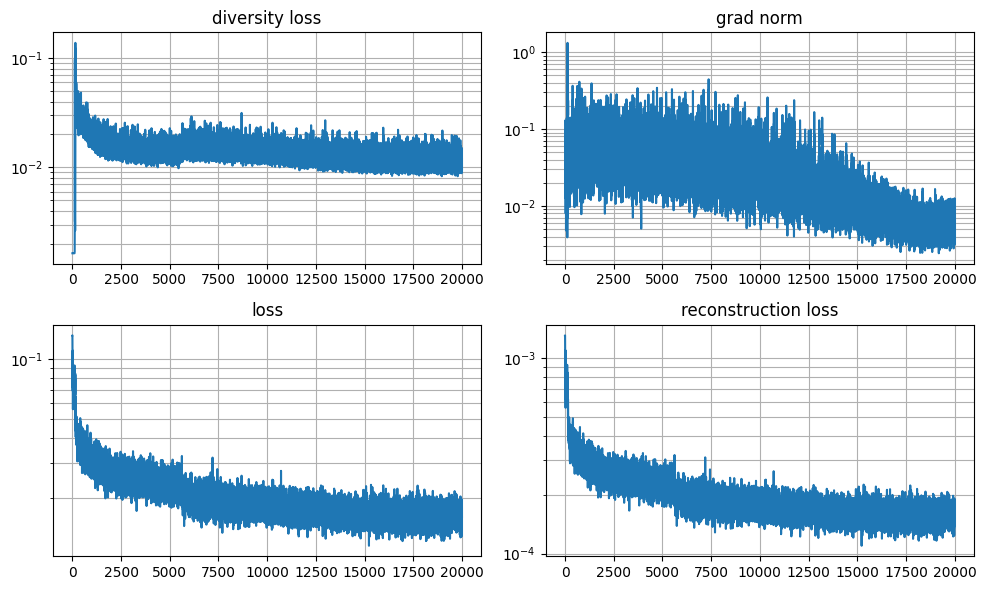

In [3]:
progbar = tqdm.trange(cfg.decay_steps, mininterval=1)
logs = defaultdict(list)
try:
    with mesh:
        for step, batch in zip(progbar, dataset):
            loss, log_dict = train_step(model, optimizer, batch, temperature=1.0)
            progbar.set_postfix(log_dict, refresh=False)
            for k, v in log_dict.items(): logs[k].append(v.item())
finally:
    plot_logs(logs)

In [4]:
print("original:")
sample = dataset.data[None, :model.valid_length(4096)]
display(Audio(sample.squeeze(), rate=dataset.sr))

print("round-trip:")
prediction = roundtrip(model, sample)
display(Audio(prediction.squeeze(), rate=dataset.sr))

original:


round-trip:
